In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import PIL.Image as Image

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## `grace hopper`

In [6]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_RES = 224

In [7]:
model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

Let's get an image and try to predict using this model. We also need to resize it (that's specified in the blog) and convert into numpy array (not specified?).

In [14]:
grace_hopper = Image.open('grace_hopper.jpg')

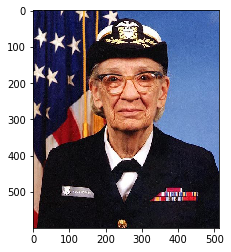

In [15]:
plt.imshow(grace_hopper);

In [16]:
grace_hopper.size

(512, 600)

In [17]:
grace_hopper = grace_hopper.resize((IMAGE_RES, IMAGE_RES))

In [18]:
grace_hopper.size

(224, 224)

In [19]:
grace_hopper_arr = np.array(grace_hopper) / 255.

In [20]:
grace_hopper_arr.shape

(224, 224, 3)

In [21]:
grace_hopper_arr_batch = np.expand_dims(grace_hopper_arr, axis=0)

In [22]:
grace_hopper_arr_batch.shape

(1, 224, 224, 3)

Now we may use our model to predict a class (both a class index and its name). And we get a correct answer: `military uniform`.

In [23]:
result = model.predict(grace_hopper_arr_batch)

In [24]:
result.shape

(1, 1001)

In [25]:
predicted_class = np.argmax(result[0])

In [26]:
predicted_class

653

In [27]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [28]:
labels_path

'/Users/ilyarudyak/.keras/datasets/ImageNetLabels.txt'

In [29]:
labels = open(labels_path).read().splitlines()

In [30]:
labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [31]:
labels[653]

'military uniform'

## cats and dogs - prediction

### get data

So `tfds` are `tf` datasets. We may load them using `load`:

> with_info: bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.

> as_supervised: bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.

Splits are not quite clear but it looks like that we're getting all the data (`train, val and test`) and somehow weighting `val` data.

In [33]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

In [35]:
train_examples, validation_examples = splits

In [36]:
train_examples

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [37]:
num_examples = info.splits['train'].num_examples

In [38]:
num_examples

23262

In [41]:
num_classes = info.features['label'].num_classes

In [42]:
num_classes

2

In [44]:
for image, label in train_examples.take(3):
    print(image.shape, label)

(500, 343, 3) tf.Tensor(1, shape=(), dtype=int64)
(375, 500, 3) tf.Tensor(0, shape=(), dtype=int64)
(375, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


It looks like this is a number of all examples, not only training examples.

In [45]:
len(list(train_examples))

18622

In [46]:
len(list(validation_examples))

4640

In [47]:
18622 + 4640

23262

In [50]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

In [51]:
BATCH_SIZE = 32

In [55]:
train_batches = train_examples \
                    .shuffle(num_examples//4) \
                    .map(format_image) \
                    .batch(BATCH_SIZE) \
                    .prefetch(1)

In [59]:
# no shuffling for val images
validation_batches = validation_examples \
                        .map(format_image) \
                        .batch(BATCH_SIZE) \
                        .prefetch(1)

### predict using our model

In [60]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [61]:
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32,))

In [62]:
result_batch = model.predict(image_batch)

In [63]:
result_batch.shape

(32, 1001)

In [65]:
imagenet_labels = np.array(labels)

In [66]:
imagenet_labels.shape

(1001,)

In [67]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

In [68]:
predicted_class_names.shape

(32,)

In [69]:
predicted_class_names[:5]

array(['rock python', 'tabby', 'Italian greyhound',
       'bicycle-built-for-two', 'tiger cat'], dtype='<U30')

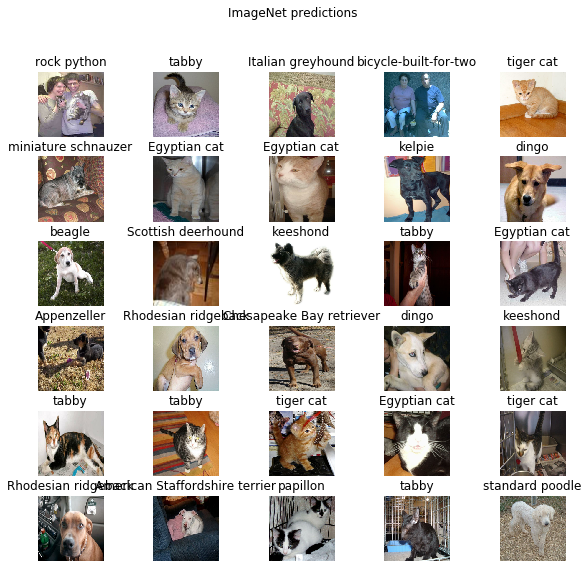

In [70]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## cats and dogs - transfer learning

In [71]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [72]:
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [73]:
feature_batch = feature_extractor(image_batch)

In [74]:
feature_batch.shape

TensorShape([32, 1280])

In [75]:
feature_extractor.trainable = False

In [77]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax')
])

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [79]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [80]:
EPOCHS = 6

In [ ]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)